# Standard methods for anomaly detection

TBD: introduction

## Wine dataset

Wine dataset is a quite popular and it contains **178** different observations, each described with **13** continuous variables with the following meaning:

1. Alcohol
2. Malic acid
3. Ash
4. Alcalinity of ash
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavanoid phenols
9. Proanthocyanins
10. Color intensity
11. Hue
12. OD280/OD315 of diluted wines
13. Proline 

In [42]:
%matplotlib inline

import pandas as pd

wine_df = pd.read_csv("./dataset/wine/wine.data")
wine_df.head().T

,1,1,1,1,1
alcohol,14.23,13.20,13.16,14.37,13.24
malic_acid,1.71,1.78,2.36,1.95,2.59
ash,2.43,2.14,2.67,2.50,2.87
alcalinity_of_ash,15.60,11.20,18.60,16.80,21.00
magnesium,127.00,100.00,101.00,113.00,118.00
total_phenols,2.80,2.65,2.80,3.85,2.80
flavanoids,3.06,2.76,3.24,3.49,2.69
nonflavanoid_phenols,0.28,0.26,0.30,0.24,0.39
proanthocyanins,2.29,1.28,2.81,2.18,1.82
color_intensity,5.64,4.38,5.68,7.80,4.32


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadffd5f8d0>,
      dtype=object)

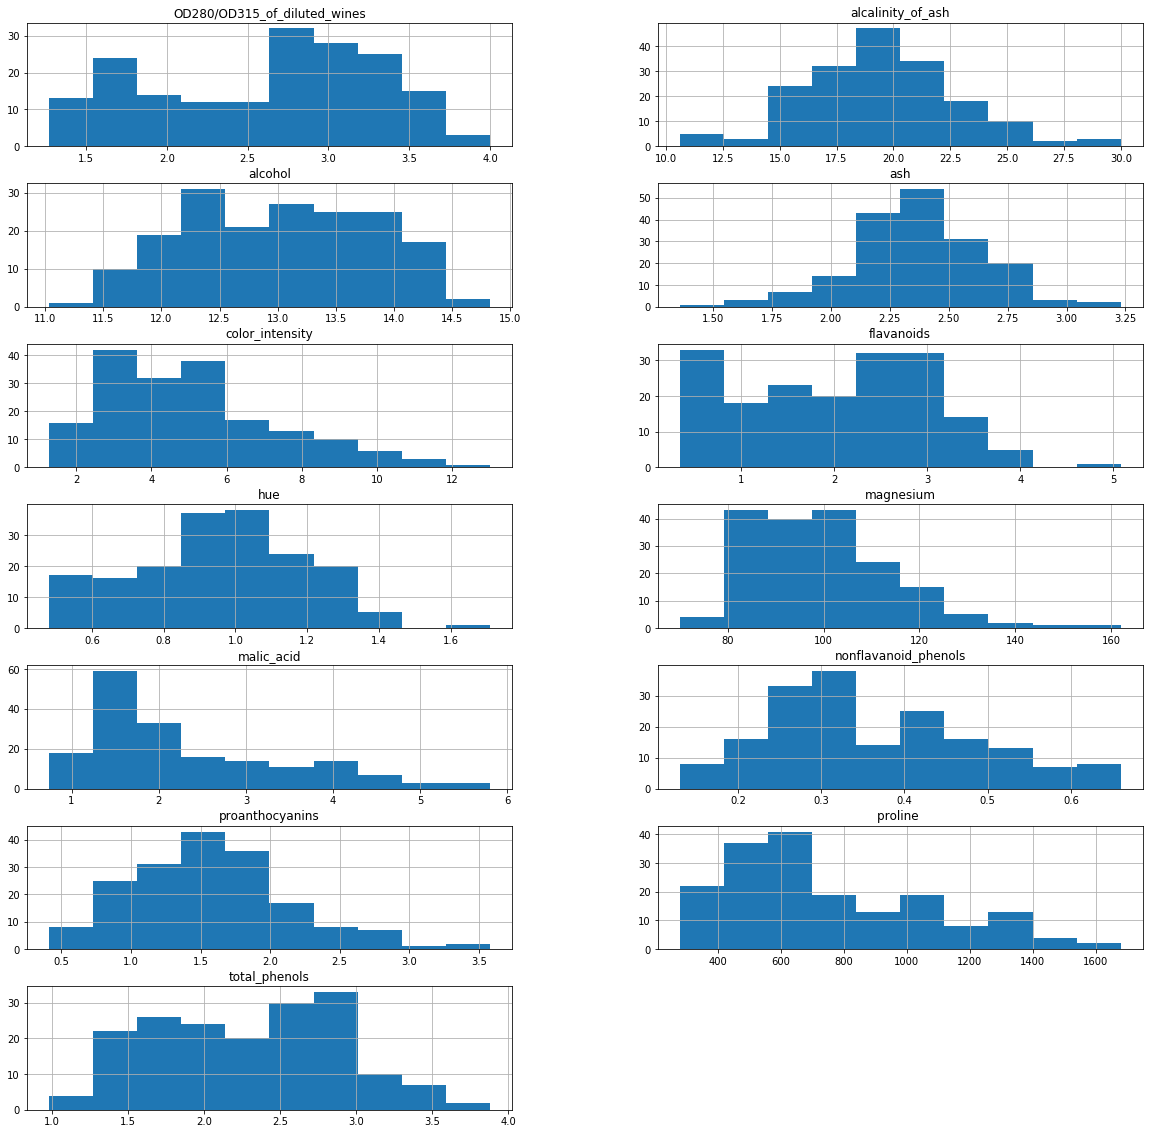

In [43]:
wine_df.hist(figsize=(20, 20), layout=(-1, 2))

## Normal / Gaussian distribution

TBD: short description (mean, variance, standard deviation, intuitions)

### Alcohol content

Just by looking at the histogram of the alcohol content, we might have an impression it is not normally distributed, however for some larger datasets it turns to follow Gaussian distribution. Due to that, we will assume it is normal and estimate the parameters.

In [11]:
mean = wine_df["alcohol"].mean()
var = wine_df["alcohol"].var()
mean, var

(13.00061797752809, 0.6590623278105759)

Having the sample mean and variance, we can plot it along with the histogram.

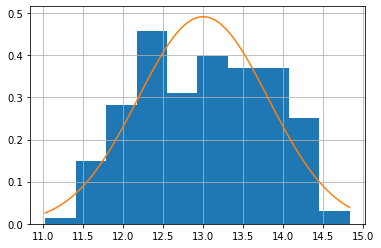

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

# Display normalized histogram
wine_df["alcohol"].hist(density=True)

# Display Gaussian distribution
stddev = np.sqrt(var)
x = np.linspace(min(wine_df["alcohol"]), max(wine_df["alcohol"]), 100)
plt.plot(x, norm.pdf(x, mean, stddev))

## Z-score 

One of the methods, which are commonly used to measure the distance of the observation to the expected values, is called **z-score**. It tells the number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured. Observed values above the mean have positive standard scores, while values below the mean have negative standard scores. 

$$ z = \frac{x - μ}{σ} $$

- $ μ $ - mean of the population
- $ σ $ - standard deviation


In [44]:
zscore_df = pd.DataFrame.from_dict(
    {"alcohol": wine_df["alcohol"], 
     "zscore": (wine_df["alcohol"] - mean) / stddev})
zscore_df.reset_index(inplace=True, drop=True)
zscore_df.head()

,alcohol,zscore
0,14.23,1.514341
1,13.20,0.245597
2,13.16,0.196325
3,14.37,1.686791
4,13.24,0.294868


In [45]:
zscore_df.loc[[zscore_df["zscore"].idxmin(),
               zscore_df["zscore"].idxmax()]]

,alcohol,zscore
115,11.03,-2.427388
8,14.83,2.253415


We can easily see that high absolute value of z-score is an indicator of being an anomaly.

The last thing to decide on is to how to recognize the anomalies, and thresholding is the simplest approach. There are following facts:

- A z-score of +1.96 cuts off the top 2.5% of the distribution and a -1.96 cuts off the bottom 2.5% of the distribution, so it cuts off 5% of the scores
- A z-score of +2.58 cut off 1% of scores
- A z-score of +3.29 cut off 0.1% of scores

## Multivariate z-score

Z-score is quite a useful measurement, assuming the variable follows a normal distribution, but it can be calculated for a single dimension only. That makes it unapplicable if we would like to check the observation as a whole.

In [56]:
people_df = pd.read_csv("./dataset/weight-height/weight-height.csv")\
    .drop("Gender", axis=1)
people_df.head()

,Height,Weight
0,73.847017,241.893563
1,68.781904,162.310473
2,74.110105,212.740856
3,71.730978,220.042470
4,69.881796,206.349801


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadff42dc88>,
      dtype=object)

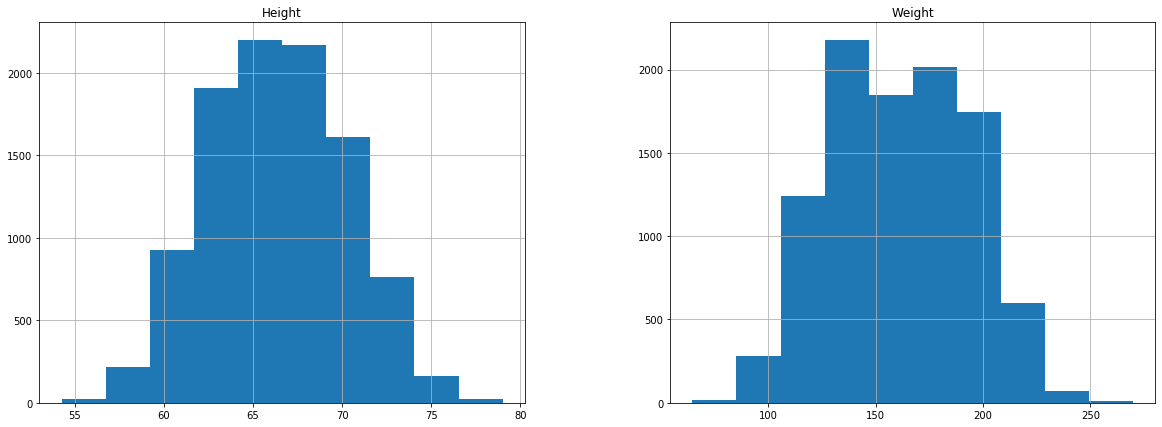

In [57]:
people_df.hist(figsize=(20, 7), layout=(1, 2))

In [58]:
people_df.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


If we consider the dimensions separately, we can recognize people the highest or the heaviest people in the population. However, if we are interested in recognizing over- or underweight, both factors have to be considered together.

## Mahalanobis distance

Mahalanobis distance plays the same role, like z-score does in univariate data analysis, and can be thought to be an extension of it, but for multivariate data analysis. This distance assumes the variance might be different in each direction, takes the covariance into consideration and reduces to Euclidean distance if all the variables are uncorrelated.

$$ D_{M}(x) = \sqrt{(x - μ)^{T} S^{-1} (x - μ)} $$

- $ μ $ - mean of the population
- $ S $ - covariance matrix


In [72]:
from scipy.spatial.distance import mahalanobis
from scipy import linalg

mean = people_df.mean().values
cov = people_df.cov().values
invcov = linalg.inv(cov)

mahalanobis_dist = people_df.apply(lambda x: mahalanobis(x, mean, invcov), 
                                   axis=1)
people_df["dist"] = mahalanobis_dist
people_df.head()

,Height,Weight,dist
0,73.847017,241.893563,2.690713
1,68.781904,162.310473,1.583281
2,74.110105,212.740856,2.127875
3,71.730978,220.042470,1.981707
4,69.881796,206.349801,1.718633


In [75]:
people_df.nlargest(5, "dist")

,Height,Weight,dist
7821,65.263062,100.982899,4.259864
1243,62.063836,175.071171,3.993489
727,63.400423,185.188138,3.894559
1317,78.462053,227.342565,3.862921
9774,65.816653,110.488487,3.824570
